# Import

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
import joblib
from sklearn.linear_model import LinearRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression,  RandomForestRegressor, GBTRegressor
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.model_selection import GridSearchCV
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split



# Start SparkSession

In [2]:
spark = SparkSession.builder.appName("StudentGPA").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/10 17:34:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Read Dataset from Hadoop

In [3]:
df = spark.read.csv("/DoAn/Raw_Dataset_Knn.csv", header=True, inferSchema=True)


# Linear Regression (7 semester's GPAs, No cross validation)

In [36]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = assembler.transform(df).select("features", "dtbhk_8")

train_df, test_df = data.randomSplit([0.8, 0.2], seed=40)

lr = LinearRegression(featuresCol="features", labelCol="dtbhk_8",
                      regParam=0.1, elasticNetParam=0.5)  
lr_model = lr.fit(train_df)
prediction = lr_model.transform(test_df)

prediction.select("features", "dtbhk_8", "prediction").show()


+--------------------+-------+------------------+
|            features|dtbhk_8|        prediction|
+--------------------+-------+------------------+
|[0.0,-1.0,1.75,3....|   6.38| 4.733779867758156|
|[0.0,-1.0,1.92,3....|   4.97|5.5621774727556454|
|[0.0,-1.0,2.39,3....|   4.44| 4.657814859997409|
|[0.0,-1.0,2.45,0....|   5.06| 4.329534220935121|
|[0.0,-1.0,2.46,2....|   3.12| 4.484130937329561|
|[0.0,-1.0,2.51,1....|    5.6| 3.617560932548696|
|[0.0,-1.0,2.67,1....|   4.44| 3.014052143906518|
|[0.0,-1.0,2.91,6....|   6.57| 6.185117038480373|
|[0.0,-1.0,2.94,2....|   3.42|3.9859659037091566|
|[0.0,-1.0,3.53,3....|   4.65| 4.179678141536671|
|[0.0,-1.0,3.53,3....|    5.0| 5.487753400378497|
|[0.0,-1.0,3.64,3....|    2.1|4.5113446394216625|
|[0.0,-1.0,3.71,2....|   6.45| 6.897043657152527|
|[0.0,-1.0,3.73,4....|   2.02| 2.329012163780356|
|[0.0,-1.0,4.0,1.6...|   3.51|3.3994021177151845|
|[0.0,-1.0,4.12,2....|   7.15|7.3259756361542925|
|[0.0,-1.0,4.12,3....|   5.05|3.9627229385847595|


In [37]:
summary = lr_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)

RMSE: 1.1039581291967941
R2: 0.6340318976898516
MSE: 1.2187235510196859
MAE: 0.7746812422480976


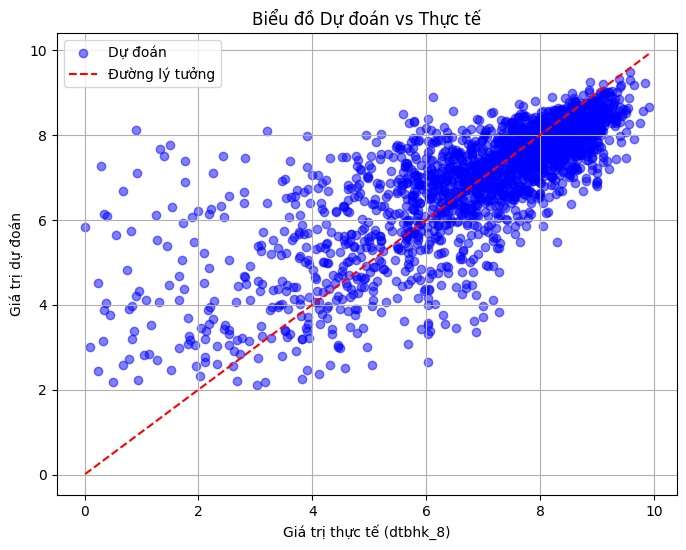

In [38]:
pred_df = prediction.select("dtbhk_8", "prediction").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(pred_df["dtbhk_8"], pred_df["prediction"], alpha=0.5, color='blue', label='Dự đoán')
plt.plot([pred_df["dtbhk_8"].min(), pred_df["dtbhk_8"].max()],
         [pred_df["dtbhk_8"].min(), pred_df["dtbhk_8"].max()],
         color='red', linestyle='--', label='Đường lý tưởng')

plt.xlabel("Giá trị thực tế (dtbhk_8)")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Dự đoán vs Thực tế")
plt.legend()
plt.grid(True)
plt.show()


# Linear Regression with Cross validation ( 6 Semester GPA's )

Best regParam: 0.01
Best elasticNetParam: 0.0
+-------+------------------+
|dtbhk_7|        prediction|
+-------+------------------+
|    8.2| 7.807488916279935|
|   8.41| 8.738790344219458|
|   6.92| 7.953154411267226|
|   8.55| 7.581626945594211|
|    8.2| 8.287312041190644|
|   8.53| 8.342931663467153|
|   8.22| 7.865639860342132|
|   5.82| 4.182328289228803|
|   5.22| 5.046013489224671|
|    9.3| 8.443488275391346|
|   6.69| 8.163888065487848|
|   5.01| 4.137347773095566|
|   3.25| 4.172686854287255|
|    3.7|2.5821546023887043|
|   8.93|  8.55981249897046|
|   2.83| 4.466486924399371|
|   7.28| 8.158137708974534|
|   8.12| 8.152535796454073|
|   8.45| 8.445598311488682|
|   6.41| 4.108921452099947|
+-------+------------------+
only showing top 20 rows

RMSE: 0.9876201158031888
R2: 0.6537374380012171
MSE: 0.975393493139104
MAE: 0.672974250373975


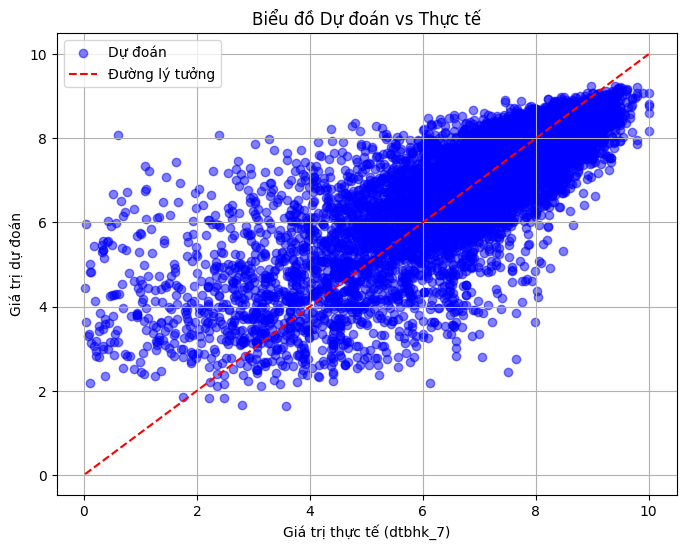

In [43]:
#6 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3', 'dtbhk_4', 'dtbhk_5', 'dtbhk_6']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_7")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_7",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_7", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_7", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
#best_model.save("/spark_model/linear_logistic_6")
pred_df = predictions.select("dtbhk_7", "prediction").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(pred_df["dtbhk_7"], pred_df["prediction"], alpha=0.5, color='blue', label='Dự đoán')
plt.plot([pred_df["dtbhk_7"].min(), pred_df["dtbhk_7"].max()],
         [pred_df["dtbhk_7"].min(), pred_df["dtbhk_7"].max()],
         color='red', linestyle='--', label='Đường lý tưởng')

plt.xlabel("Giá trị thực tế (dtbhk_7)")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Dự đoán vs Thực tế")
plt.legend()
plt.grid(True)
plt.show()


# Linear Regression with Cross validation ( 5 Semester GPA's )

In [47]:
#5 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3', 'dtbhk_4', 'dtbhk_5']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_6")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_6",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_6", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_6", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
#best_model.save("/spark_model/linear_logistic_5")



Best regParam: 0.01
Best elasticNetParam: 0.0
+-------+------------------+
|dtbhk_6|        prediction|
+-------+------------------+
|   7.85|  7.60238582726612|
|   8.74| 8.798390304461485|
|   8.09| 7.647265576395403|
|   7.28| 7.920440123396569|
|   8.15| 8.478015441852577|
|   8.89| 7.929827804436454|
|    7.4|  8.40095581900804|
|   3.31| 4.668943901520323|
|   6.27| 2.978326660645552|
|   8.63| 8.589151581032006|
|   8.33| 7.978877130328449|
|   2.54| 4.666211633846432|
|   2.86| 4.631165978373986|
|   1.21|3.0249308946888784|
|    9.0| 8.159183952951768|
|    3.9| 4.384239705557925|
|   8.72| 7.392950612778156|
|   8.63| 7.943976218125936|
|   8.67| 8.336730527561164|
|   3.34|3.6436834264969433|
+-------+------------------+
only showing top 20 rows

RMSE: 0.9983321370124203
R2: 0.6734939298319331
MSE: 0.9966670557917859
MAE: 0.6716103542907507


# Linear Regression with Cross validation ( 4 Semester GPA's )

In [ ]:
#4 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3', 'dtbhk_4']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_5")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_5",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_5", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_5", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
#best_model.save("/spark_model/linear_logistic_4")


Best regParam: 0.01
Best elasticNetParam: 0.0
+-------+------------------+
|dtbhk_5|        prediction|
+-------+------------------+
|   7.19|7.6637681395864155|
|   8.54| 8.712585646207172|
|   7.86| 7.393286073432884|
|   7.46| 8.154435540337285|
|   8.56|  8.19763744713694|
|   8.04| 7.745995679212427|
|   8.85|7.9777048103159265|
|   5.18| 3.503727549846692|
|    1.1| 4.636922904319738|
|   8.89| 8.026349520931909|
|    7.5| 8.109270283697974|
|   3.63| 5.578888705733001|
|   3.69| 5.367329175819224|
|   2.96|2.7541579378082903|
|   8.27|7.7542650655785925|
|   3.89| 4.523224423167744|
|    6.1|   8.4992668527516|
|   8.25| 7.520434095665863|
|   8.33| 7.986328063999731|
|    2.2|  5.15408763178291|
+-------+------------------+
only showing top 20 rows

RMSE: 1.038501750751985
R2: 0.6197008626210532
MSE: 1.0784858863149378
MAE: 0.7085823156837189


# Linear Regression with Cross validation ( 3 Semester GPA's )

In [ ]:
#3 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_4")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_4",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_4", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_4", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
#best_model.save("/spark_model/linear_logistic_3")


25/05/10 19:12:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/10 19:12:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Best regParam: 0.01
Best elasticNetParam: 0.0
+-------+------------------+
|dtbhk_4|        prediction|
+-------+------------------+
|   7.71|  7.60271787438763|
|   8.75| 9.068276242019829|
|   8.32| 6.535448629358635|
|   8.05| 8.439381425495068|
|   8.41| 7.925931217442564|
|   7.87| 7.523435339968408|
|   8.49| 7.400192651658671|
|   1.57| 4.992466706001134|
|   3.33|  5.87344532205084|
|   7.92| 8.271871060843697|
|   8.08| 8.310524852948312|
|   5.63| 5.278242938570473|
|   4.58| 5.581979737258585|
|   0.92| 3.860539828318692|
|   8.06| 7.639135191434914|
|   3.32| 5.487926817799677|
|   8.92| 8.241945374343706|
|   7.32|7.9869134103534085|
|   8.01| 8.193374962397566|
|   4.93|  4.42955448180871|
+-------+------------------+
only showing top 20 rows

RMSE: 1.0086530122220216
R2: 0.6482068030543106
MSE: 1.0173808990645576
MAE: 0.6874867167188214


# Linear Regression with Cross validation ( 7 Semester GPA's )

In [49]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_8")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_8",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_8", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
#best_model.save("/spark_model/linear_logistic_7")



Best regParam: 0.01
Best elasticNetParam: 0.5
+-------+------------------+
|dtbhk_8|        prediction|
+-------+------------------+
|   7.93|7.9498518070885655|
|   8.83| 8.529047160517633|
|    7.8| 7.547885799419585|
|   7.24| 7.989235464081856|
|   8.05| 8.212672154112486|
|   8.81| 8.330340077419358|
|   9.03| 8.015994414442408|
|   5.04| 4.820504126445283|
|   4.93| 5.055257347418217|
|   8.55| 8.767105532846976|
|   8.68| 7.499004090966496|
|   5.05| 4.605537165869771|
|   3.48|  3.68201486329445|
|   0.86|3.0133580484337035|
|   8.62|  8.75077116740596|
|    2.7| 3.721693212895209|
|   5.66|7.7147703876133145|
|   8.53| 8.141106654078195|
|    8.7| 8.459916357895803|
|   4.49|4.9826937389722445|
+-------+------------------+
only showing top 20 rows

RMSE: 1.1102852729519737
R2: 0.6308375310978744
MSE: 1.2327333873340387
MAE: 0.7735129424581754


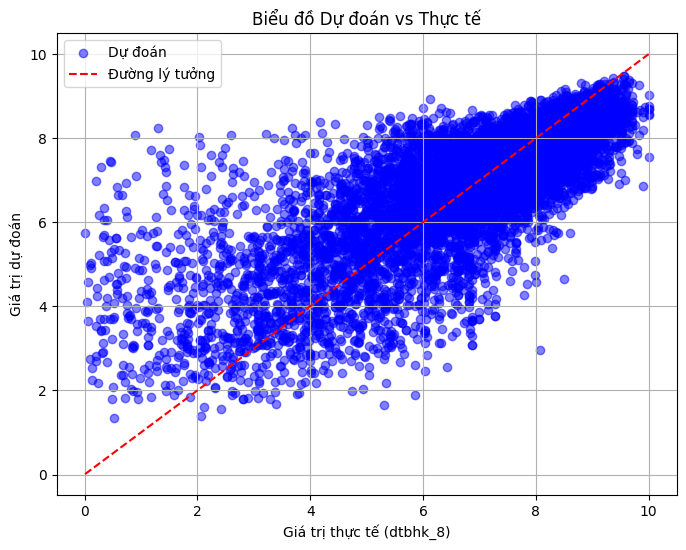

In [52]:
pred_df = predictions.select("dtbhk_8", "prediction").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(pred_df["dtbhk_8"], pred_df["prediction"], alpha=0.5, color='blue', label='Dự đoán')
plt.plot([pred_df["dtbhk_8"].min(), pred_df["dtbhk_8"].max()],
         [pred_df["dtbhk_8"].min(), pred_df["dtbhk_8"].max()],
         color='red', linestyle='--', label='Đường lý tưởng')

plt.xlabel("Giá trị thực tế (dtbhk_8)")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Dự đoán vs Thực tế")
plt.legend()
plt.grid(True)
plt.show()

# Random Forest ( 6 Semester's GPA )

In [ ]:
# 6 hoc ki
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4', 'dtbhk_5', 'dtbhk_6']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)

# 
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

data = assembled_data.select("features", "dtbhk_7")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_7", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="dtbhk_7", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

rmse = RegressionEvaluator(labelCol="dtbhk_7", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_7", predictionCol="prediction", metricName="mae").evaluate(predictions)

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

rf_model.save("/spark_model/random_forest_6")

R2: 0.6512896246506732
RMSE: 0.9826424428918585
MAE: 0.6743883423441456


# Random Forest ( 5 Semester's GPA )

In [ ]:
# 5 hoc ki
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4', 'dtbhk_5']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)


# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

data = assembled_data.select("features", "dtbhk_6")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_6", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="dtbhk_6", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

rmse = RegressionEvaluator(labelCol="dtbhk_6", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_6", predictionCol="prediction", metricName="mae").evaluate(predictions)

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

rf_model.save("/spark_model/random_forest_5")

R2: 0.6938273126502077
RMSE: 0.9393143032471808
MAE: 0.6498408869137726


# Random Forest ( 4 Semester's GPA )

In [ ]:
# 4 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)

# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

data = assembled_data.select("features", "dtbhk_5")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_5", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="dtbhk_5", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

rmse = RegressionEvaluator(labelCol="dtbhk_5", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_5", predictionCol="prediction", metricName="mae").evaluate(predictions)

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

rf_model.save("/spark_model/random_forest_4")

R2: 0.6244381369278817
RMSE: 1.0332850858972975
MAE: 0.6914531535275148


# Random Forest ( 3 Semester's GPA )

In [ ]:
# 3 hoc ki 
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)

# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

data = assembled_data.select("features", "dtbhk_4")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_4", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="dtbhk_4", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

rmse = RegressionEvaluator(labelCol="dtbhk_4", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_4", predictionCol="prediction", metricName="mae").evaluate(predictions)

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

rf_model.save("/spark_model/random_forest_3")

R2: 0.6612058845368816
RMSE: 0.9867672106316814
MAE: 0.6863667951459295


# Random Forest ( 7 Semester's GPA )

In [ ]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)

# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

data = assembled_data.select("features", "dtbhk_8")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_8", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

rmse = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="mae").evaluate(predictions)

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

rf_model.save("/spark_model/random_forest_7")


R2: 0.6328478513389482
RMSE: 1.116451542696801
MAE: 0.7725235225691776


# Gradient Boosted Tree

In [29]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = assembler.transform(df).select("features", "dtbhk_8")

train_df, test_df = data.randomSplit([0.8, 0.2], seed=40)

gbt = GBTRegressor(featuresCol="features", labelCol="dtbhk_8", maxIter=100)
gbt_model = gbt.fit(train_df)
gbt_prediction = gbt_model.transform(test_df)

gbt_prediction.select("features", "dtbhk_8", "prediction").show()
evaluator = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(gbt_prediction)

rmse = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="rmse").evaluate(gbt_prediction)
mae = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="mae").evaluate(gbt_prediction)

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")



+--------------------+-------+------------------+
|            features|dtbhk_8|        prediction|
+--------------------+-------+------------------+
|[0.0,-1.0,1.75,3....|   6.38| 5.448879413654358|
|[0.0,-1.0,1.92,3....|   4.97| 5.014327986203086|
|[0.0,-1.0,2.39,3....|   4.44| 4.254420094901856|
|[0.0,-1.0,2.45,0....|   5.06| 5.410129376578747|
|[0.0,-1.0,2.46,2....|   3.12|  5.13412123540393|
|[0.0,-1.0,2.51,1....|    5.6| 5.478771965147534|
|[0.0,-1.0,2.67,1....|   4.44| 4.197727224224477|
|[0.0,-1.0,2.91,6....|   6.57|7.1894002518602536|
|[0.0,-1.0,2.94,2....|   3.42|3.6088704802075817|
|[0.0,-1.0,3.53,3....|   4.65|3.4987050176393746|
|[0.0,-1.0,3.53,3....|    5.0|  6.05017411252384|
|[0.0,-1.0,3.64,3....|    2.1|3.2698790337523134|
|[0.0,-1.0,3.71,2....|   6.45| 6.867580297370542|
|[0.0,-1.0,3.73,4....|   2.02|2.9371397806438515|
|[0.0,-1.0,4.0,1.6...|   3.51|3.0533650546121236|
|[0.0,-1.0,4.12,2....|   7.15| 6.521005748908099|
|[0.0,-1.0,4.12,3....|   5.05| 2.975704799146808|


# XGboost (7 Semester's GPA )

R2 score: 0.656047094275117
mean_squared_error:  1.1649243236849798
mean_absolute_error:  0.7450706316583718


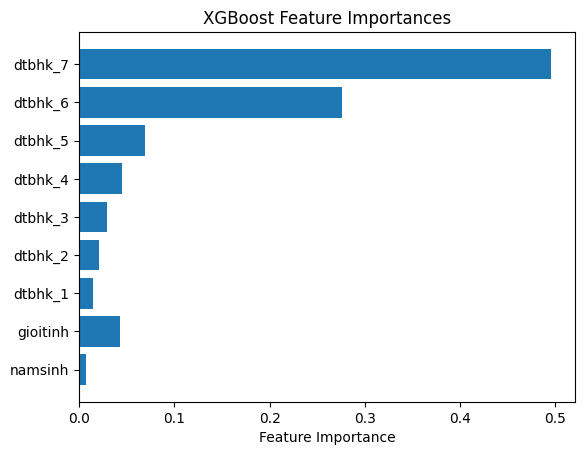

Luu thanh cong


In [ ]:

pdf = df.toPandas()  # convert từ PySpark về Pandas

X = pdf[['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']]
y = pdf['dtbhk_8']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R2 score:", r2_score(y_test, y_pred))
print("mean_squared_error: " , mean_squared_error(y_test, y_pred))
print("mean_absolute_error: ", mean_absolute_error(y_test, y_pred))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importances")
plt.show()
try:
    #joblib.dump(model, "./saved_model/xgboost_7.pkl")
    print("Luu thanh cong")
except Exception as e:
    print("Luu loi")



25/05/09 14:13:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


===== Model Performance on Test Data =====
RMSE: 1.1287495773230236
R2: 0.6247147294773217
MAE: 0.7803581851943993
Best regParam: 0.01
Best elasticNetParam: 0.3
Best solver: auto

Feature Importance:
dtbhk_7: 0.40661441968721507
weight_recent: 0.3099644232078707
dtbhk_6: 0.2793775047062193
dtbhk_7_squared: 0.20544416872180474
dtbhk_4: 0.17336524195484027
dtbhk_1: -0.0976246113366174
dtbhk_5: 0.09630580708760615
dtbhk_3: 0.08005580228403926
avg_dtb: 0.07435510245207887
namsinh: -0.02240910896354245
gioitinh: -0.007641724961361268
dtbhk_2: 0.0
trend: 0.0
rec_trend: 0.0
